In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

import sys
from paths import Paths
paths = Paths()
sys.path.append(paths.scripts_root)
import util

%load_ext autoreload
%autoreload 2

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

paths.print_paths()

Paths defined in paths module:
 paths.data_root: /Users/trafferty/data
 paths.notebook_root: /Users/trafferty/data/notebooks
 paths.scripts_root: /Users/trafferty/data/scripts
 paths.images_root: /Users/trafferty/data/images
 paths.projects_root: /Users/trafferty/data/projects
 paths.results_root: /Users/trafferty/data/results
 paths.tmp_root: /Users/trafferty/data/tmp
 paths.tmp_dir: /Users/trafferty/tmp
 paths.ws_dir: /Users/trafferty/workspace
 paths.mii_home: /Users/trafferty/dev
 paths.inhouse: /Users/trafferty/dev/src/inhouse


### Read in an image, some anotation, plotting

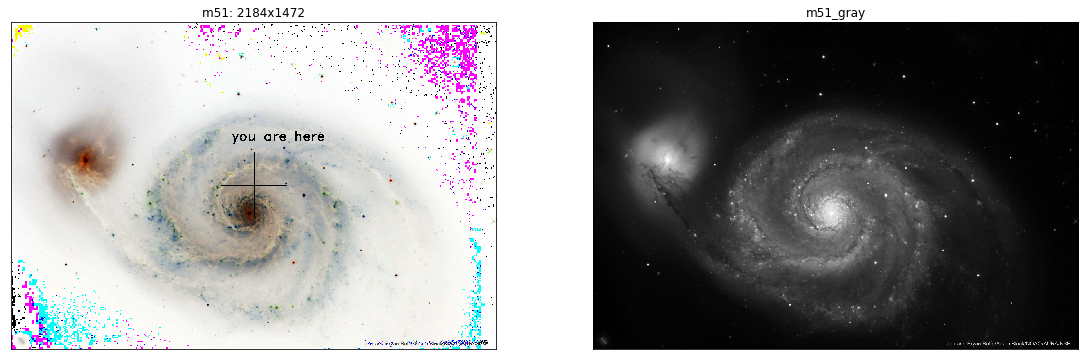

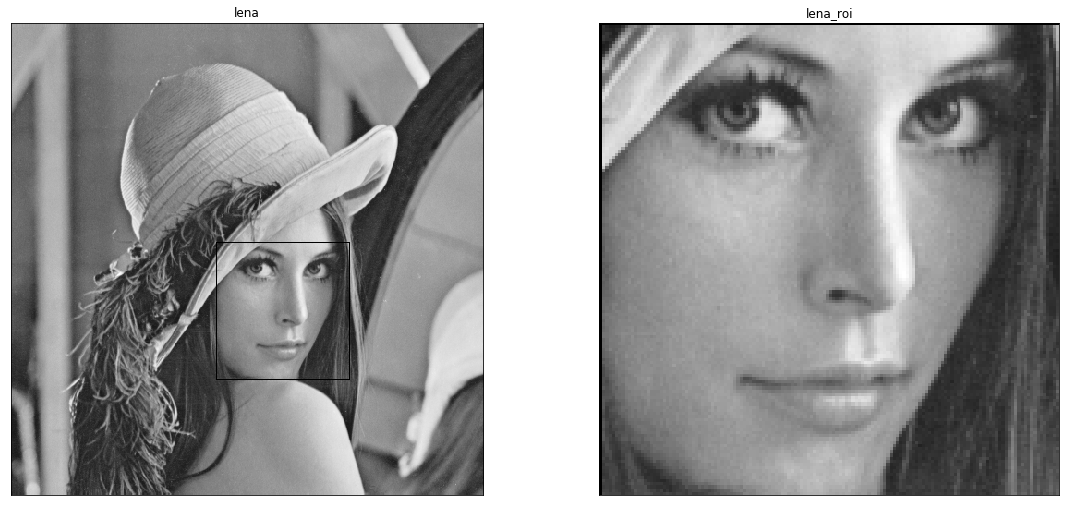

In [3]:
m51 = cv2.imread(paths.images_root+'/m51.jpg' ,cv2.IMREAD_COLOR)
m51_gray = cv2.cvtColor(m51, cv2.COLOR_BGR2GRAY)
green = (0, 255, 0)

lena = cv2.imread(paths.images_root+'/lena-16g.png',cv2.IMREAD_GRAYSCALE)
lena_roi = lena[238:386, 222:366]  #np slice: [startY:endY, startX:endX]
cv2.rectangle(lena, (222, 238), (366, 386), green, 1) # two corners: (startX, startY), (endX, endY)

rows, cols, channels = m51.shape
midX, midY = int(cols/2), int(rows/2)
l = int(min([rows,cols]) * 0.1)
cv2.line(m51, (midX, midY-l), (midX, midY+l), green, 3)
cv2.line(m51, (midX-l, midY), (midX+l, midY), green, 3)
cv2.putText(m51, "you are here", (midX-100, midY-200), cv2.FONT_HERSHEY_DUPLEX, 2, green, 3)

util.plot_imgs([(m51,'m51: %dx%d' % (cols,rows)), (m51_gray, 'm51_gray'), 
            (lena, 'lena'), (lena_roi, 'lena_roi')], max_cols = 2)

99.2244897959
99.2448979592


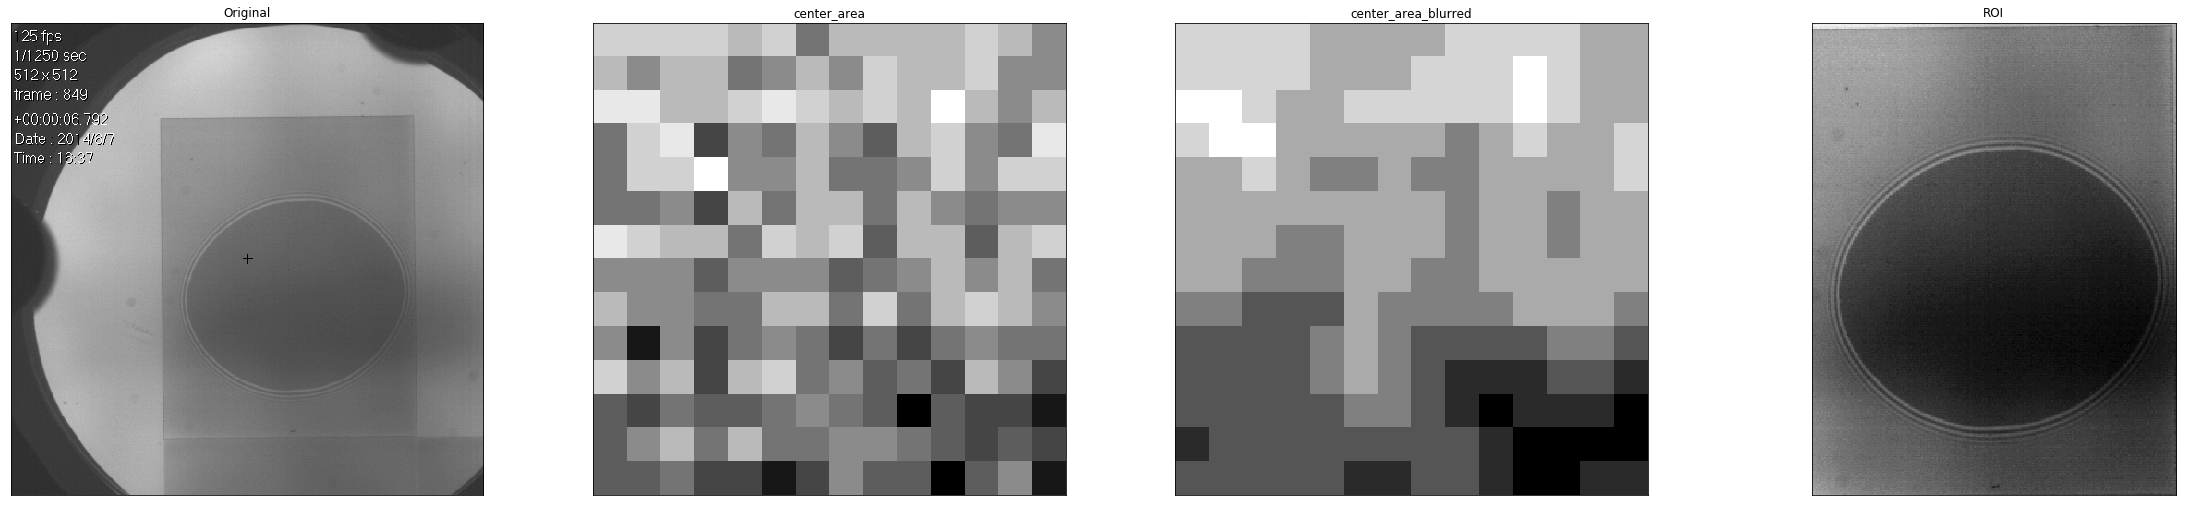

In [8]:
img = cv2.imread(paths.projects_root+'/contact_front/EFF/ContactFront-040.png',cv2.IMREAD_GRAYSCALE)
rows, cols = img.shape

img_annotate = img.copy()
midX, midY = int(cols/2), int(rows/2)
center_area = img[midY-7:midY+7, midX-7:midX+7]
center_area_blurred = cv2.GaussianBlur(center_area, (3, 3), 0)

img_roi = img[99:449, 170:440]

green = (0, 255, 0)
cv2.line(img_annotate, (midX, midY-5), (midX, midY+5), green)
cv2.line(img_annotate, (midX-5, midY), (midX+5, midY), green)
#cv2.rectangle(img, (midY-7, midX-7), (midY+7, midX+7), green)

print(center_area.mean())
print(center_area_blurred.mean())

util.plot_imgs([(img_annotate,'Original'), (center_area, 'center_area'), 
            (center_area_blurred, 'center_area_blurred'), (img_roi, 'ROI')], max_cols = 4)

### Some thresholding...

In [ ]:
retval, thresh = cv2.threshold(img, 145, 255, cv2.THRESH_BINARY)

blurred = cv2.GaussianBlur(img, (7, 7), 0)
#blurred = cv2.medianBlur(img, 5)
#blurred = cv2.bilateralFilter(img, 11, 17, 17)

# (src, dst, maxValue, adaptive_method, thresholdType, blockSize=3, C=5) # 'C' is subtracted from the mean
thresh_mean = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 9, 4)
thresh_gaus = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 3)

# if C == 0, image topography shows up well (here, 'topography' is likely due to lossy jpeg compression)
img_topog = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 7, 0)


util.plot_imgs([(thresh, 'thresh'), (thresh_mean, 'thresh_mean'), 
                (thresh_gaus, 'thresh_gaus'), (img_topog, 'thresh_mean, no subtraction')], max_cols = 4)

### Histograms...

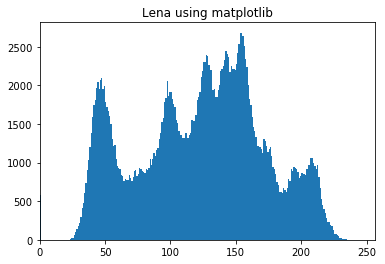

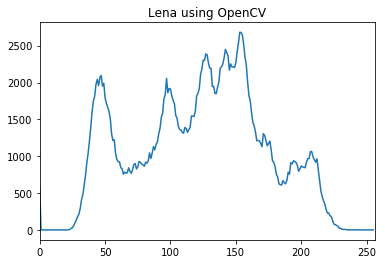

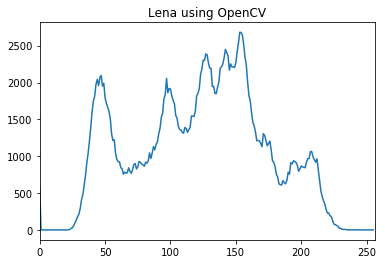

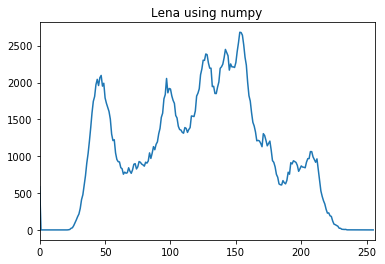

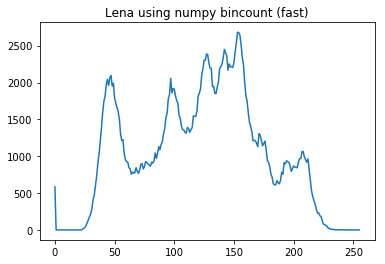

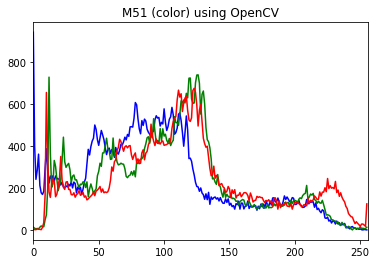

In [5]:
#using matplotlib
plt.hist(lena.ravel(),256,[0,256])
plt.xlim([0,256])
plt.title('Lena using matplotlib')
plt.show()

# using opencv
histr = cv2.calcHist([lena],[0],None,[256],[0,256])
plt.plot(histr)
plt.title('Lena using OpenCV')
plt.xlim([0,256])
plt.show()

# using numpy
hist,bins = np.histogram(lena.ravel(),256,[0,256])
plt.plot(hist)
plt.xlim([ bins[0], bins[-1] ])
plt.title('Lena using numpy')
plt.show()

hist = np.bincount(lena.ravel(),minlength=256)
plt.plot(hist)
plt.title('Lena using numpy bincount (fast)')
plt.show()

# color using opencv
owl = cv2.imread('../images/owl.jpg',cv2.IMREAD_COLOR)
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([owl],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.title('M51 (color) using OpenCV')
plt.show()


### Use histogram and 'countNonZero' to find number of black pixels 

In [ ]:
img_lst = []
#img = cv2.imread(paths.images_root+'/blob.jpg',cv2.IMREAD_GRAYSCALE)
img = cv2.imread(paths.tmp_dir+'/process/process_img_636-511--300.png',cv2.IMREAD_GRAYSCALE)
img = img[100:800, 100:1100]
(rows, cols) = img.shape[:2]

img_lst.append( (img,u'input img') )

total_pixels = img.size
print("Total pixels: ", total_pixels)

histr = cv2.calcHist([img],[0],None,[2],[0,1])
print( "(Hist) Black pixels: ", histr[0])

print( "(countNonZero) Black pixels: ", (total_pixels - cv2.countNonZero(img)))


plt.plot(histr)
plt.title(u'Lena using OpenCV')
plt.xlim([-10,256])
plt.show()

util.plot_imgs(img_lst)


### Histogram Equalization

In [ ]:
lena_equalized = cv2.equalizeHist(lena)
m51_gray_equalized = cv2.equalizeHist(m51_gray)

util.plot_imgs([(lena_equalized,u'lena_equalized'), (m51_gray_equalized, u'm51_gray_equalized')])

### BLOBing...

In [ ]:
img_lst = []
#img = cv2.imread('../images/blob.jpg',cv2.IMREAD_GRAYSCALE)
img = cv2.imread('../tmp/process/process_img_636-511--300.png',cv2.IMREAD_GRAYSCALE)
img = img[100:800, 100:1100]

img_lst.append( (img,'input img') )

# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 1;
params.maxThreshold = 250;
 
# Filter by Area.
params.filterByArea = False
# params.minArea = 1500
 
# Filter by Circularity
params.filterByCircularity = False
# params.minCircularity = .1
 
# # Filter by Convexity
params.filterByConvexity = False
# params.minConvexity = 0.87
 
# # Filter by Inertia
params.filterByInertia = False
# params.minInertiaRatio = 0.9

params.filterByColor = False
params.filterByArea = True
params.minArea = 20.0
params.maxArea = 5000000.0

 
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs.
keypoints = detector.detect(img)
print( len(keypoints))

if len(keypoints):
    # Draw detected blobs as red circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img_lst.append( (im_with_keypoints,'Keypoints') )

# Show keypoints
util.plot_imgs(img_lst)

### Edge detection...

In [ ]:
laplacian = cv2.Laplacian(img,cv2.CV_64F)
laplacian = np.uint8(np.absolute(laplacian))
sobelX = cv2.Sobel(img,cv2.CV_64F, 1, 0, ksize=3)
sobelX = np.uint8(np.absolute(sobelX))
sobelY = cv2.Sobel(img,cv2.CV_64F, 0, 1, ksize=3)
sobelY = np.uint8(np.absolute(sobelY))
sobelCombined = cv2.bitwise_or(sobelX, sobelY)
util.plot_imgs([(laplacian,'laplacian'), (sobelX, 'sobel X'), 
           (sobelY, 'sobel Y'), (sobelCombined, 'sobel Combined')], max_cols=4)

### Canny edge detection...

In [ ]:
img_blurred = cv2.GaussianBlur(img, (3, 3), 0)
#img_blurred = cv2.bilateralFilter(img, 11, 17, 17)
canny = cv2.Canny(img_roi, 20, 60, apertureSize=3, L2gradient=True)

util.plot_imgs([(img_blurred,'img_blurred'), (canny,'canny')])

### Using Canny, contours and moments to find feature loc, area, etc

In [ ]:
img_lst = []
#img = cv2.imread('../images/blob.jpg',cv2.IMREAD_GRAYSCALE)
img = cv2.imread('../tmp/process/process_img_636-511--300.png',cv2.IMREAD_GRAYSCALE)
img = img[100:800, 100:1100]
(rows, cols) = img.shape[:2]

img_lst.append( (img,'input img') )

canny_output = cv2.Canny(img, 50, 150, apertureSize=3, L2gradient=True)
img_lst.append( (canny_output,'canny_output') )

# Find contours
contour_img, contours, hierarchy = cv2.findContours(canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img_lst.append( (contour_img,'contour_img') )

# Get the moments
mu_lst = []
for contour in contours:
    mu = cv2.moments(contour, False)
    mu_lst.append(mu)

#vector<Point2f> mc( contours.size() );
mc_lst = []
for i, contour in enumerate(contours):
    mu = mu_lst[i]
    mc = ( (mu['m10']/mu['m00']), (mu['m01']/mu['m00']) )
    print( mc)
    mc_lst.append(mc)

# Draw contours
#Mat drawing = Mat::zeros( canny_output.size(), CV_8UC3 );
drawing  = np.zeros((rows, cols, 3), np.uint8)
for i, contour in enumerate(contours):
    cv2.drawContours( drawing, contours, i, (128,255,255), 3, cv2.LINE_AA, hierarchy, 0 )
    cp = (int(mc_lst[i][0]), int(mc_lst[i][1]) )
    cv2.circle(drawing, cp, 4, (255,0,0),4)    

img_lst.append( (drawing,'drawing') )

#Calculate the area with the moments 00 and compare with the result of the OpenCV function
print("Info: Area and Contour Length");
for i, contour in enumerate(contours):
    area = cv2.contourArea(contour)
    arc_length = cv2.arcLength( contour, True )
    print(" * Contour[%d] - Area (M_00) = %.2f - Area OpenCV: %.2f - Length: %.2f" % (i, mu_lst[i]['m00'], area, arc_length) )


util.plot_imgs(img_lst)

### Color Channel Separation...

In [ ]:
img_color = cv2.imread('../projects/contact_front/MR/2015_05_29-013.png',cv2.IMREAD_COLOR)
print( "Shape: %s" % (img_color.shape,))

plot_lst = []
plot_lst.append( (img_color, 'img_color') )

img_hsv = cv2.cvtColor(img_color, cv2.COLOR_BGR2HSV)
plot_lst.append( (img_hsv, 'img_hsv') )

chan = ('0','1','2')
for chan_idx, chan in enumerate(chan):
    chan_img = cv2.split(img_hsv)[chan_idx]
    plot_lst.append( (chan_img, 'img_hsv - chan %d' % (chan_idx)) )

util.plot_imgs(plot_lst, max_cols=5)

plot_lst = []
(rows, cols) = img_color.shape[:2]

blue_chan  = np.zeros((rows, cols, 3), np.uint8)
green_chan = np.zeros((rows, cols, 3), np.uint8)
red_chan   = np.zeros((rows, cols, 3), np.uint8)

blue_chan[:,:,0] = img_color[:,:,0]
green_chan[:,:,1] = img_color[:,:,1]
red_chan[:,:,2] = img_color[:,:,2]

plot_lst.append( (blue_chan, 'blue_chan') )
plot_lst.append( (green_chan, 'green_chan') )
plot_lst.append( (red_chan, 'red_chan') )
util.plot_imgs(plot_lst, color=True)

plot_lst = []

blue_chan  = img_color.copy()
blue_chan[:,:,1] = 0
blue_chan[:,:,2] = 0
plot_lst.append( (blue_chan, 'blue_chan') )

green_chan = img_color.copy()
green_chan[:,:,0] = 0
green_chan[:,:,2] = 0
plot_lst.append( (green_chan, 'green_chan') )

red_chan   = img_color.copy()
red_chan[:,:,0] = 0
red_chan[:,:,1] = 0
plot_lst.append( (red_chan, 'red_chan') )

util.plot_imgs(plot_lst, color=True)


### SubImaging


In [ ]:
def subimage_old(image, centre, theta, width, height):
    output_image = cv.CreateImage((width, height), image.depth, image.nChannels)
    mapping = np.array([[np.cos(theta), -np.sin(theta), centre[0]],
                       [np.sin(theta), np.cos(theta), centre[1]]])
    map_matrix_cv = cv.fromarray(mapping)
    cv.GetQuadrangleSubPix(image, output_image, map_matrix_cv)
    return output_image

def subimage(img, centre, theta, width, height):
    row,col = img.shape[:2]
    #output_image = cv.CreateImage((width, height), img.depth, img.nChannels)
    #output_image = np.zeros(img.shape, np.uint8)
    output_image = np.zeros((width, height), np.uint8)
    
    mapping = np.array([[np.cos(theta), -np.sin(theta), centre[0]],
                       [np.sin(theta), np.cos(theta), centre[1]]])
   
    #map_matrix_cv = cv.fromarray(mapping)
    map_matrix_cv = mapping
    
    #cv2.GetQuadrangleSubPix(img, output_image, map_matrix_cv)
    output_image = cv2.warpAffine(img, map_matrix_cv, (col, row)) 
    #output_image = cv2.warpAffine(img, map_matrix_cv, (width, height), output_image) 
    return output_image

def subimage2(image, center, theta, width, height):
    #theta = np.deg2rad(theta)

    v_x = (np.cos(theta), np.sin(theta))
    v_y = (-np.sin(theta), np.cos(theta))
    s_x = center[0] - v_x[0] * (width / 2) - v_y[0] * (height / 2)
    s_y = center[1] - v_x[1] * (width / 2) - v_y[1] * (height / 2)

    mapping = np.array([[v_x[0],v_y[0], s_x],
                        [v_x[1],v_y[1], s_y]])

    return cv2.warpAffine(image,mapping,(width, height),flags=cv2.WARP_INVERSE_MAP,borderMode=cv2.BORDER_REPLICATE)

img = cv2.imread('../images/owl.jpg', -1)
print( img.shape)
patch = subimage2(img, (110, 125), np.pi / 6.0, 100, 200)


cv2.rectangle(img, (110, 125), (200, 225), util.red, 1)
plt.cla()
plt.imshow(img),plt.title('Owl'), plt.xticks([]), plt.yticks([])
plt.figure()
plt.imshow(patch),plt.title('Owl Patch'), plt.xticks([]), plt.yticks([])


In [ ]:
from IPython import display
import pylab as pl

def calcChanMeans(img):
    chan1  = frame_roi.copy()
    chan1[:,:,1] = 0
    chan1[:,:,2] = 0
    chan1_mean = np.abs(np.mean(chan1))

    chan2 = frame_roi.copy()
    chan2[:,:,0] = 0
    chan2[:,:,2] = 0
    chan2_mean = np.abs(np.mean(chan2))

    chan3   = frame_roi.copy()
    chan3[:,:,0] = 0
    chan3[:,:,1] = 0
    chan3_mean = np.abs(np.mean(chan3))
    return (chan1_mean, chan2_mean, chan3_mean)

video_file_path = '../projects/contact_front/MR_NewCam/2015-08-04_DFI28.mp4'

cap = cv2.VideoCapture(video_file_path)

cnt = 0
chan1 = []
chan2 = []
chan3 = []
while(cap.isOpened()):
    ret, frame = cap.read()
    cnt += 1
    
    # the following shows each fram dynamically, but is very slow and resource
    # intensive.  need to figure out how to make it more efficient...
    if False:
        #print('Frame # %d' % cnt)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        plt.imshow(frame)
        plt.title('Frame # %d' % cnt), plt.xticks([]), plt.yticks([])
        #pl.plot(gray)
        display.clear_output(wait=True)
        display.display(plt.gcf())
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HLS)
        (rows, cols) = frame.shape[:2]
        cp = (cols/2, rows/2)
        frame_roi = frame[cp[1]-10:cp[1]+10, cp[0]-10:cp[0]+10]  #np slice: [startY:endY, startX:endX]

#         blue_chan  = frame_roi.copy()
#         blue_chan[:,:,1] = 0
#         blue_chan[:,:,2] = 0
#         blue_chan_mean = np.abs(np.mean(blue_chan))
#         chan1.append(blue_chan_mean)

#         green_chan = frame_roi.copy()
#         green_chan[:,:,0] = 0
#         green_chan[:,:,2] = 0
#         green_chan_mean = np.abs(np.mean(green_chan))
#         chan2.append(green_chan_mean)

#         red_chan   = frame_roi.copy()
#         red_chan[:,:,0] = 0
#         red_chan[:,:,1] = 0
#         red_chan_mean = np.abs(np.mean(red_chan))
#         chan3.append(red_chan_mean)
        chan_means = calcChanMeans(frame_roi)
        chan1.append(chan_means[0])
        chan2.append(chan_means[1])
        chan3.append(chan_means[2])
    else:
        cnt -= 1
        break
print( "Processing complete, extracted/analyzed ", cnt, " images...")
print( "Found ", len(chan1), " data pts:")
cap.release()

In [ ]:
plt.figure(figsize=(10*2,5))
plt.plot(chan1[190:], color='b')
plt.plot(chan2[190:], color='g')
plt.plot(chan3[190:], color='r')
# plt.vlines(lt_peakIdx, 0, np.max(patch_diff) + 25, color='r')
# plt.vlines(rt_peakIdx, 0, np.max(patch_diff) + 25, color='r')
plt.title('HLS mean values from center ROI')

In [ ]:
%matplotlib inline
import time
import pylab as pl
from IPython import display
for i in range(10):
    pl.plot(pl.randn(100))
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(1.0)

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import datetime

# Create the PdfPages object to which we will save the pages:
# The with statement makes sure that the PdfPages object is closed properly at
# the end of the block, even if an Exception occurs.
with PdfPages('../results/multipage_pdf.pdf') as pdf:
    plt.figure(figsize=(3, 3))
    plt.plot(range(7), [3, 1, 4, 1, 5, 9, 2], 'r-o')
    plt.title('Page One')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

    plt.rc('text', usetex=True)
    plt.figure(figsize=(8, 6))
    x = np.arange(0, 5, 0.1)
    plt.plot(x, np.sin(x), 'b-')
    plt.title('Page Two')
    pdf.savefig()
    plt.close()

    plt.rc('text', usetex=False)
    fig = plt.figure(figsize=(4, 5))
    plt.plot(x, x*x, 'ko')
    plt.title('Page Three')
    pdf.savefig(fig)  # or you can pass a Figure object to pdf.savefig
    plt.close()

    # We can also set the file's metadata via the PdfPages object:
    d = pdf.infodict()
    d['Title'] = u'Multipage PDF Example'
    d['Author'] = u'Tom H. Rafferty / CNT'
    d['Subject'] = u'How to create a multipage pdf file and set its metadata'
    d['Keywords'] = 'PdfPages multipage keywords author title subject'
    d['CreationDate'] = datetime.datetime(2009, 11, 13)
    d['ModDate'] = datetime.datetime.today()

Reading Raw Images

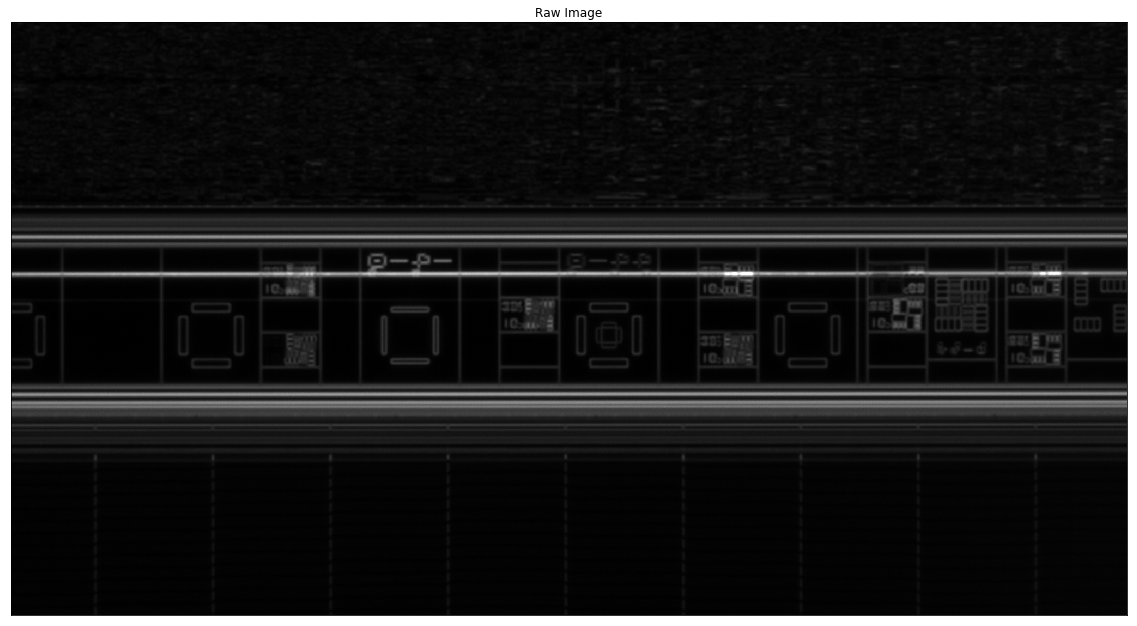

In [15]:
def readRaw(filepath, rows, cols):
    try: 
        with open(filepath, 'rb') as fd:
            raw_buf = np.fromfile(fd, dtype=np.uint8, count=rows*cols)
        return raw_buf.reshape((rows, cols)) #notice row, column format
    except FileNotFoundError:
        print("Error! File not found: %s" % (filepath))
        raise


rows = 1088
cols = 2048
filepath = '/Users/trafferty/data/images/2048x1088.raw'
im = readRaw(filepath, rows, cols)

util.plot_imgs([( im, "Raw Image")], fig_size=20)

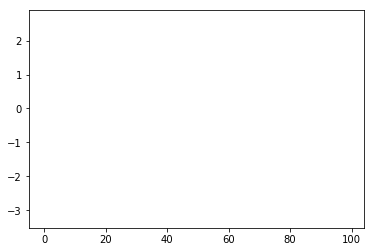

In [7]:
import time
import pylab as pl
from IPython import display
for i in range(10):
    pl.plot(pl.randn(100))
    display.display(pl.gcf())
    display.clear_output(wait=True)
    time.sleep(1.0)
    plt.cla()